## Importing all the required libraries


In [1]:
from keras.datasets import mnist
from keras.layers.core import Dense, Dropout, Activation
from keras.models import Sequential
from keras.optimizers import Adam
from keras.utils import np_utils
from keras import regularizers
from keras.regularizers import l2
from keras import backend as K
from keras.models import load_model
from keras.utils import to_categorical

from sklearn.ensemble import RandomForestClassifier
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

from numpy import dstack
from os import makedirs
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import itertools
import os

Using TensorFlow backend.


## Loading preprocessed dataset

In [2]:
dataset = pd.read_csv("./DatasetPreprocessed.csv",index_col=0)
display(dataset.head())

,Age,Total Bilirubin,Direct Bilirubin,Total Proteins,Albumin,A/G ratio,SGPT,SGOT,Alkphos,Gender_Female,Gender_Male,output disease
0,0.709302,0.004021,0.000000,0.060576,0.003015,0.001626,0.594203,0.521739,0.240,1,0,1
1,0.674419,0.140751,0.275510,0.310699,0.027136,0.018296,0.695652,0.500000,0.176,0,1,1
2,0.674419,0.092493,0.204082,0.208598,0.025126,0.011791,0.623188,0.521739,0.236,0,1,1
3,0.627907,0.008043,0.015306,0.058134,0.002010,0.002033,0.594203,0.543478,0.280,0,1,1
4,0.790698,0.046917,0.096939,0.064485,0.008543,0.009961,0.666667,0.326087,0.040,0,1,1


## Visualization

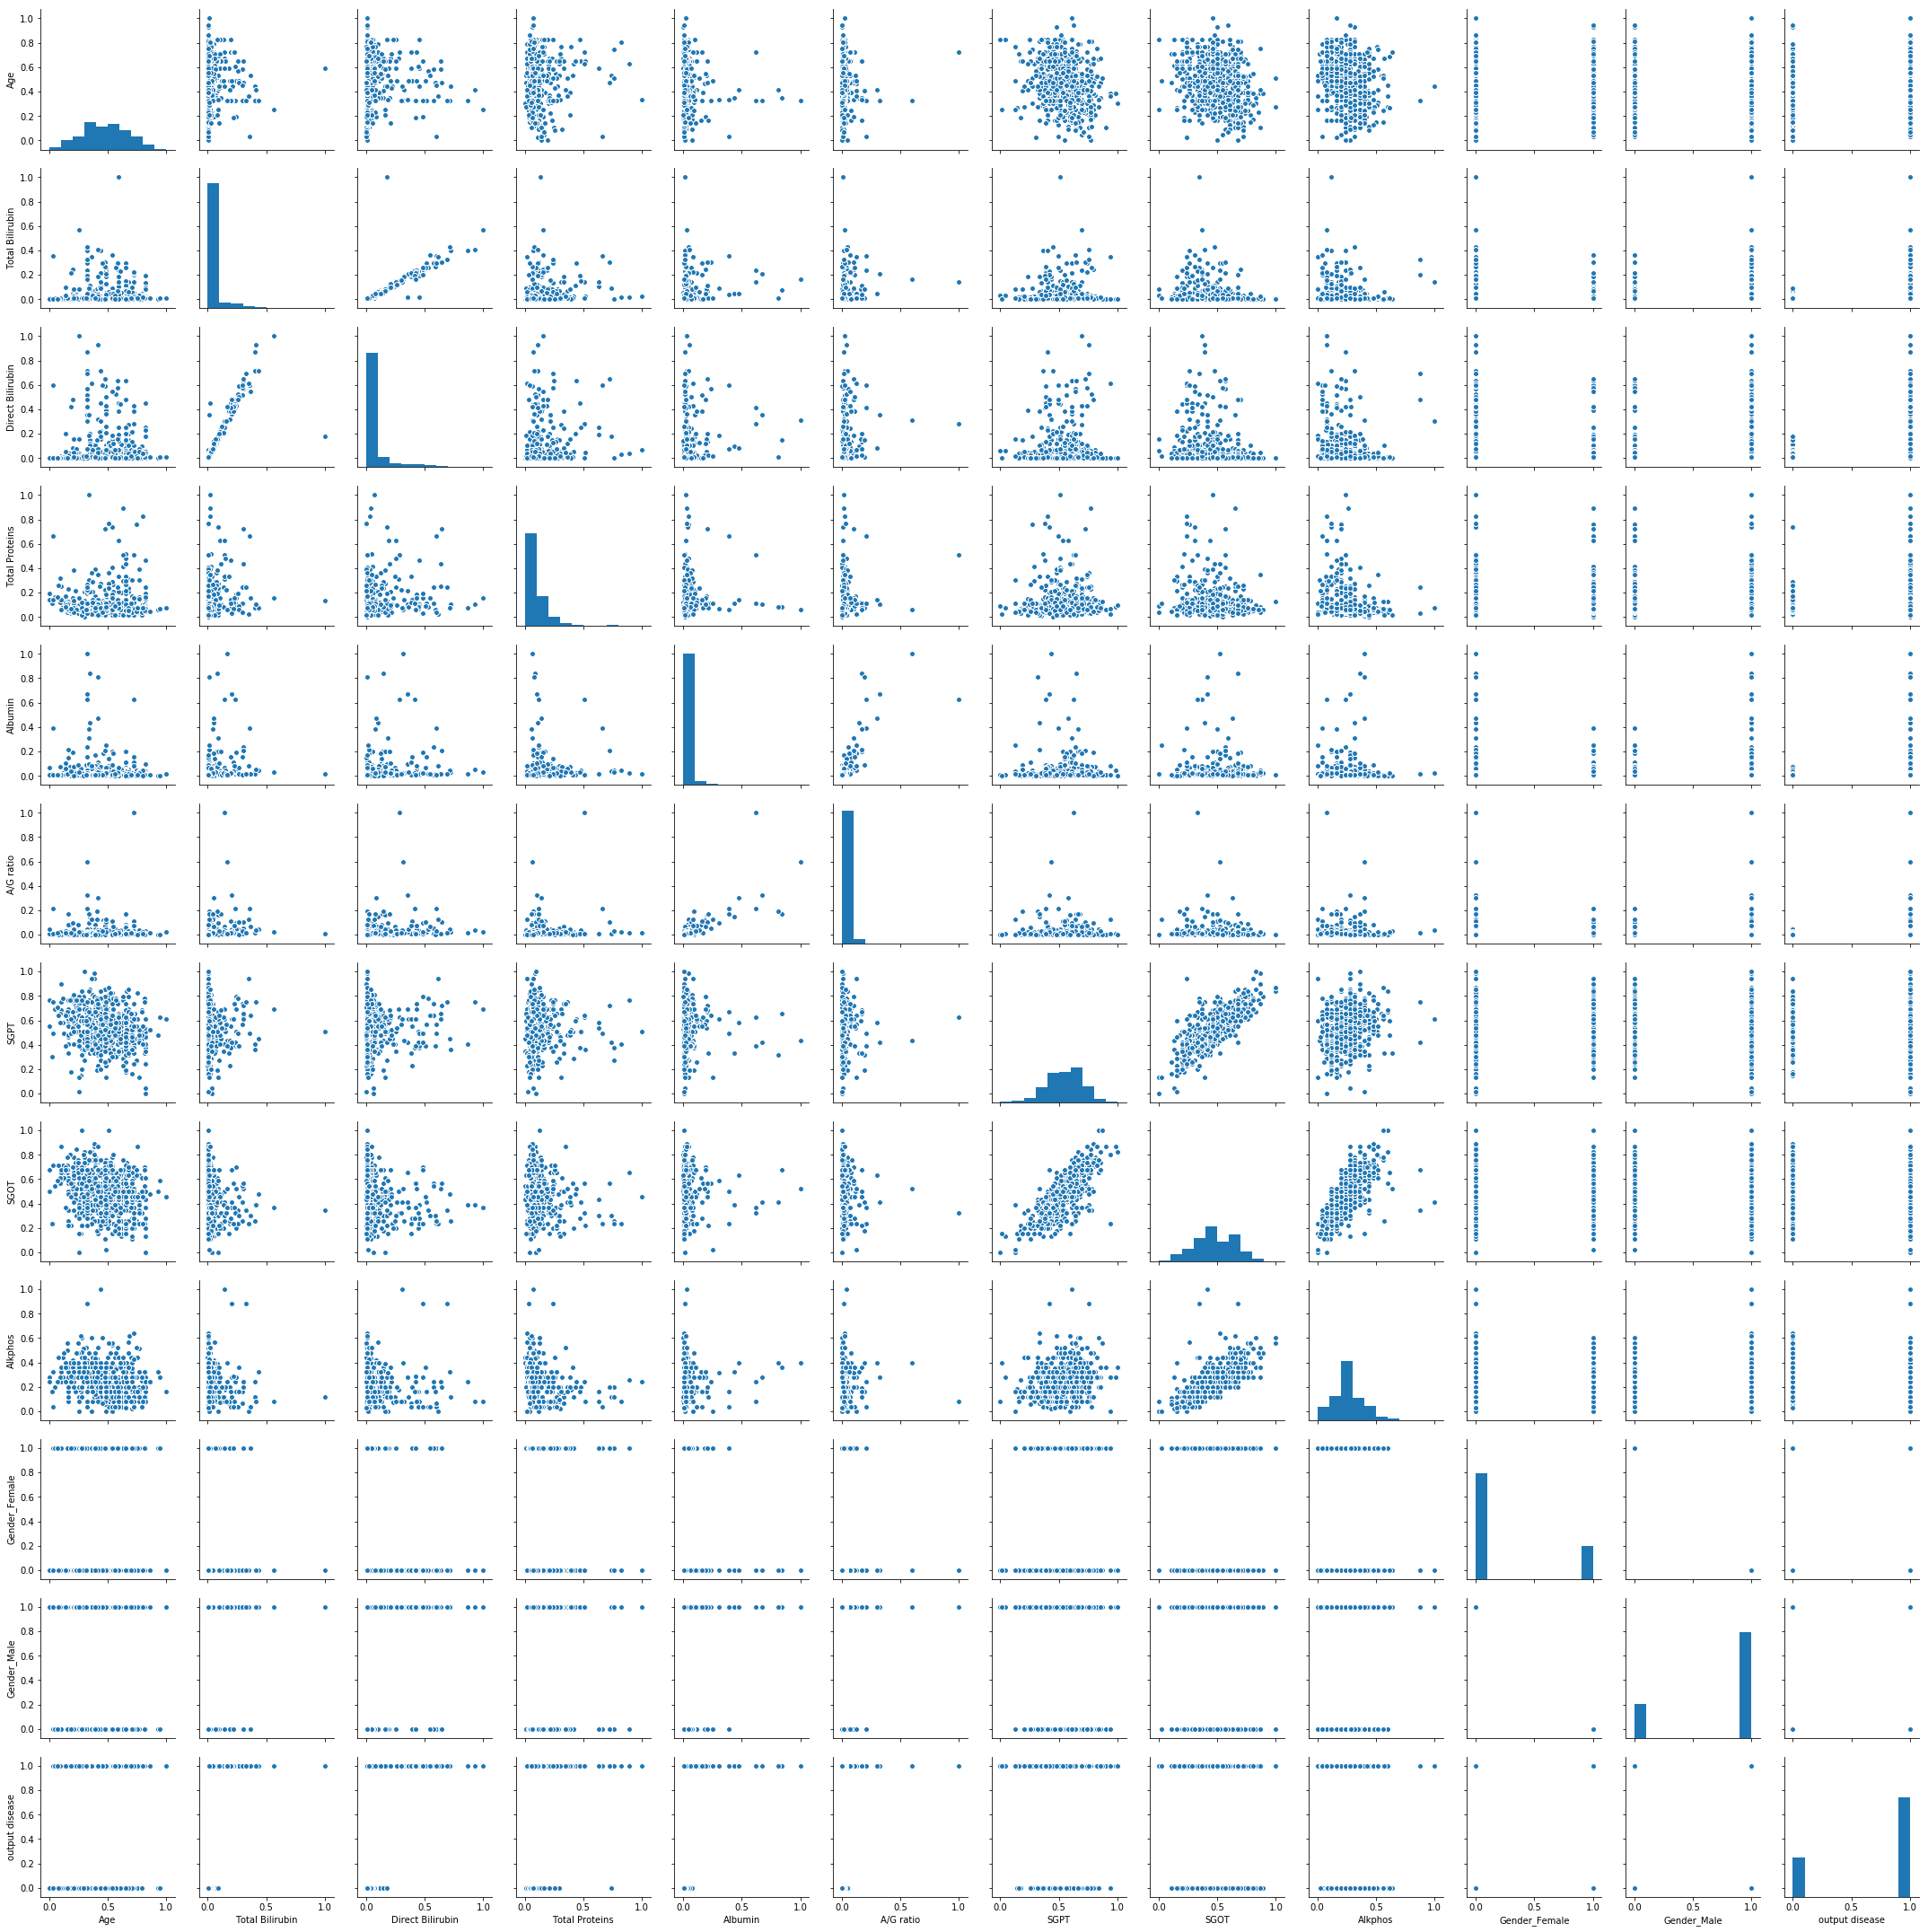

In [3]:
sns.pairplot(dataset)
plt.show()

## Split dataset (80-20)

In [4]:
x = dataset.loc[:,"Age":"Gender_Male"] 
y = dataset["output disease"]

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 50)
print ("Training set has {} samples.".format(X_train.shape))
print ("Testing set has {} samples.".format(X_test.shape))

Training set has (463, 11) samples.
Testing set has (116, 11) samples.


## setting parameters

In [5]:
epochs = 60
batch_size = 128
verbose = 0
classes = 2

optimizer = Adam()
hidden = 128
validation_split = 0.1
dropout = 0.1

## Float 32 conversion of input data

In [6]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
print("Input data shape",X_train.shape)

Input data shape (463, 11)


## encoding the output class

In [7]:
Y_train = np_utils.to_categorical(y_train, classes)
Y_test = np_utils.to_categorical(y_test, classes)

##  Neural Network

In [8]:
def fit_model(X_train,Y_train):
    def l1_reg(weight_matrix):
        return 0.2 * K.sum(K.abs(weight_matrix))

    model = Sequential()
    model.add(Dense(hidden, input_shape=(X_train.shape[1],)))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(hidden))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(classes))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    history = model.fit(X_train, Y_train, batch_size=batch_size, verbose = verbose,epochs=epochs, validation_split=validation_split)
    return model, history

## training

In [9]:
if not os.path.isdir("./models/"):
    makedirs('models')

In [10]:
n_members = 10
for i in range(n_members):
    model,history = fit_model(X_train, Y_train)
    filename = 'models/model_' + str(i + 1) + '.h5'
    model.save(filename)
    print('Saved %s' % filename)
model.summary()

Saved models/model_1.h5
Saved models/model_2.h5
Saved models/model_3.h5
Saved models/model_4.h5
Saved models/model_5.h5
Saved models/model_6.h5
Saved models/model_7.h5
Saved models/model_8.h5
Saved models/model_9.h5
Saved models/model_10.h5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_46 (Dense)             (None, 128)               1536      
_________________________________________________________________
dense_47 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_19 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_48 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_49 (Dense)             (None, 128)               16512     
_________________________________

In [11]:
def load_all_models(n_models):
    all_models = list()
    for i in range(n_models):
        filename = 'models/model_' + str(i + 1) + '.h5'
        model = load_model(filename)
        all_models.append(model)
        print('loaded %s' % filename)
    return all_models

members = load_all_models(n_members)
print('Loaded %d models' % len(members))

for model in members:
    score = model.evaluate(X_test, Y_test, verbose = verbose)
    print('Accuracy is {:.2f}%'.format((score[1])*100))

loaded models/model_1.h5
loaded models/model_2.h5
loaded models/model_3.h5
loaded models/model_4.h5
loaded models/model_5.h5
loaded models/model_6.h5
loaded models/model_7.h5
loaded models/model_8.h5
loaded models/model_9.h5
loaded models/model_10.h5
Loaded 10 models
Accuracy is 70.69%
Accuracy is 66.38%
Accuracy is 63.79%
Accuracy is 75.00%
Accuracy is 78.45%
Accuracy is 67.24%
Accuracy is 67.24%
Accuracy is 70.69%
Accuracy is 71.55%
Accuracy is 76.72%


In [12]:
# create stacked model input dataset as outputs from the ensemble
def stacked_dataset(members, inputX):
    stackX = None
    for model in members:
        # make prediction
        yhat = model.predict(inputX)
        # stack predictions into [rows, members, probabilities]
        if stackX is None:
            stackX = yhat
        else:
            stackX = dstack((stackX, yhat))
    # flatten predictions to [rows, members x probabilities]
    nsamples, nx, ny = stackX.shape
    stackX = stackX.reshape((nsamples,nx*ny))
    return stackX

def fit_stacked_model(members, inputX, inputy):
    # create dataset using ensemble
    stackedX = stacked_dataset(members, inputX)
    # fit standalone model
    model = RandomForestClassifier(n_estimators=1000)
    model.fit(stackedX, inputy)
    return model

def stacked_prediction(members, model, inputX):
    # create dataset using ensemble
    stackedX = stacked_dataset(members, inputX)
    # make a prediction
    yhat = model.predict(stackedX)
    return yhat

# fit stacked model using the ensemble
model = fit_stacked_model(members, X_test, y_test)

## Evaluation

In [13]:
yhat = stacked_prediction(members, model, X_test)
acc = accuracy_score(y_test, yhat)
print('Test Accuracy: %.3f' % acc)

Test Accuracy: 0.991


##  Confusion matrix

In [14]:
def plot_confusion_matrix(cm,classes=[0,1],normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

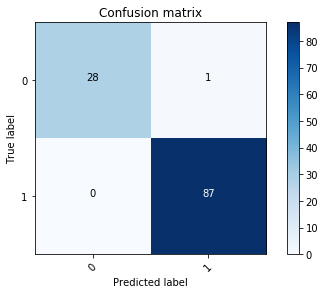

In [15]:
plt.figure()
cm = confusion_matrix(y_test, yhat)
plot_confusion_matrix(cm)
plt.savefig("confusionGrapg.jpeg", bbox_inches='tight')
plt.show()

## Classification Report

In [16]:
print(classification_report(y_test, yhat))

             precision    recall  f1-score   support

          0       1.00      0.97      0.98        29
          1       0.99      1.00      0.99        87

avg / total       0.99      0.99      0.99       116



## Graph

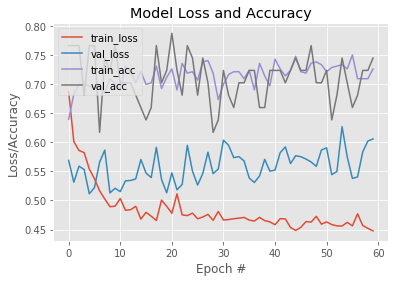

In [17]:
plt.style.use("ggplot")
plt.figure()
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Model Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc='upper left')
plt.savefig("lossAndaccuracy.jpeg")
plt.show()